In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from pathlib import Path
import os
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
from collections import defaultdict
import io
from tqdm.auto import tqdm

from PIL import Image
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error
from torchvision.transforms import v2 as transforms_v2
from pytorch_msssim import ssim, ms_ssim
import compressai

from Iwildcam_Pretrain import Autoencoder, Encoder, Decoder, IWildCamDataset, CompressaiWrapper
from lora_modules import LoRAConv2d, LoRALinear, LoRAConvTranspose2d

/data/vision/beery/scratch/timm/micromamba/envs/aecompression/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/data/vision/beery/scratch/timm/micromamba/envs/aecompression/lib/python3.12/site-packages/compressai/models/video/google.py:353: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @amp.autocast(enabled=False)
[rank: 0] Seed set to 42


Device: cuda:0


In [ ]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

CHECKPOINT_PATH = "best_checkpoints/"
# HEIGHT = 96
# WIDTH = 160
HEIGHT = 96 * 2
WIDTH = 160 * 2
PRECISION = 32
DO_CACHING = False
# DATASET_ROOT = "/data/vision/beery/scratch/data/iwildcam_unzipped"
DATASET_ROOT = "/tmp/iwildcam_unzipped"

Device: cuda:0


In [4]:
def get_lora_model(
        latent_dim,
        lora_precision=None,
        loraize_encoder = False,  # no reason really to do this unless we want to reduce memory footprint
        loraize_decoder = True,
        finetune = True,
        model_type = 'hyperprior',
):
    if finetune and lora_precision == 32:
        lora_precision = None

    lora_config = {
        torch.nn.Conv2d: {
            'cls': LoRAConv2d,
            'config': {
                'alpha': 8,
                'rank': 4,
                'rank_for': 'channels',
                'delta_bias': False, # True # TODO what does this do
                'precision': lora_precision,
            }
        },
        torch.nn.Linear: {
            'cls': LoRALinear,
            'config': {
                'rank': 4,
                'alpha': 2,
                'delta_bias':  False, # True # TODO what does this do
                'precision': lora_precision,
            }
        },
        torch.nn.ConvTranspose2d: {
            'cls': LoRAConvTranspose2d,
            'config': {
                'alpha': 8,
                'rank': 4,
                'rank_for': 'channels',
                'delta_bias': False, # True # TODO what does this do
                'precision': lora_precision,
            }
        }
    }

    # load two copies so we can lora-ize one
    if model_type == 'vanilla':
        pretrained_filename = sorted(glob.glob(os.path.join(CHECKPOINT_PATH, f"{latent_dim}-*.ckpt")))[0]
        if os.path.isfile(pretrained_filename):
            print(f"Found pretrained model '{pretrained_filename}' for latent dim {latent_dim}, loading...")
            _model = Autoencoder.load_from_checkpoint(pretrained_filename)
            model  = Autoencoder.load_from_checkpoint(pretrained_filename)
        else:
            raise Exception
    elif model_type == 'hyperprior':
        pretrained_filename = sorted(glob.glob(os.path.join(CHECKPOINT_PATH, f"{latent_dim}-*.ckpt")))[0]
        if os.path.isfile(pretrained_filename):
            print(f"Found pretrained model '{pretrained_filename}' for latent dim {latent_dim}, loading...")
            model  = CompressaiWrapper.load_from_checkpoint(pretrained_filename)
            _model = CompressaiWrapper.load_from_checkpoint(pretrained_filename)
        else:
            raise Exception
    else:
        raise ValueError('Invalid model_type')
    
    if not finetune:
        return model
    
    if model_type == 'vanilla':
        if loraize_encoder:
            for i, module in enumerate(_model.encoder.net.children()): 
                if type(module) in lora_config.keys():
                    lora_cls = lora_config[type(module)]['cls']
                    lora_params = lora_config[type(module)]['config']
                    model.encoder.net[i] = lora_cls(module, lora_params) # automatically freezes old parameters
                    model.encoder.net[i].enable_adapter()                # but we need to turn on the adapter path
                else:
                    # freeze all other parameters
                    for p in module.parameters():
                        p.requires_grad_(False)

        if loraize_decoder:
            for i, module in enumerate(_model.decoder.linear.children()): 
                if type(module) in lora_config.keys():
                    lora_cls = lora_config[type(module)]['cls']
                    lora_params = lora_config[type(module)]['config']
                    model.decoder.linear[i] = lora_cls(module, lora_params) # automatically freezes old parameters
                    model.decoder.linear[i].enable_adapter()                # but we need to turn on the adapter path
                else:
                    # freeze all other parameters
                    for p in module.parameters():
                        p.requires_grad_(False)

            for i, module in enumerate(_model.decoder.net.children()): 
                if type(module) in lora_config.keys():
                    lora_cls = lora_config[type(module)]['cls']
                    lora_params = lora_config[type(module)]['config']
                    model.decoder.net[i] = lora_cls(module, lora_params) # automatically freezes old parameters
                    model.decoder.net[i].enable_adapter()                # but we need to turn on the adapter path
                else:
                    # freeze all other parameters
                    for p in module.parameters():
                        p.requires_grad_(False)
    
    elif model_type == 'hyperprior':
            # freeze decoder stuff that won't be transmitted
        print("Freezing:")
        for name, param in model.model.g_s.named_parameters():
            print(name)
            param.requires_grad = False
        for name, param in model.model.h_s.named_parameters():
            print(name)
            param.requires_grad = False

        print("Fine-tuning:")
        for i, module in enumerate(_model.model.g_s.children()): 
            if type(module) in lora_config.keys():
                print("lora-izing", module)
                lora_cls = lora_config[type(module)]['cls']
                lora_params = lora_config[type(module)]['config']
                model.model.g_s[i] = lora_cls(module, lora_params) # automatically freezes old parameters
                model.model.g_s[i].enable_adapter()                # but we need to turn on the adapter path

        for i, module in enumerate(_model.model.h_s.children()): 
            if type(module) in lora_config.keys():
                print("lora-izing", module)
                lora_cls = lora_config[type(module)]['cls']
                lora_params = lora_config[type(module)]['config']
                model.model.h_s[i] = lora_cls(module, lora_params) # automatically freezes old parameters
                model.model.h_s[i].enable_adapter()                # but we need to turn on the adapter path
    else:
        raise ValueError('Invalid model_type')

    del _model # get rid of the clone
    return model

In [5]:
def compute_bits_per_pixel(model, latent_size, lora_precision, width, height, finetune):
    param_size = 0
    if finetune:
        for name, param in model.named_parameters():
            # if "delta" in name:
            if param.requires_grad:
                param_size += param.nelement() * ((lora_precision / 8) if lora_precision != 0 else (32 / 8))

    # assume we don't have to transmit these if they are fixed -- this would be alpha, rank hyperparams
    buffer_size = 0

    param_bpp = 8 * (param_size + buffer_size) / (width * height)
    latent_bpp = 8 * latent_size / (width * height)

    return param_bpp, latent_bpp

In [ ]:
our_test_set_ids = [292, 181, 430, 20, 4]
# our_test_set_ids = [4]  # TODO: remove
latent_dim = 8
max_epochs = 10
# max_epochs = 1  # TODO: remove

results = []

for lora_precision in [-1, 0, 4, 8, 32]:
    finetune = lora_precision != -1
    finetune_lora = lora_precision > 0

    for loc_id in our_test_set_ids:

        # release memory
        try:
            del test_set
            del model
            del trainer
            torch.cuda.empty_cache()
        except:
            pass

        test_set = IWildCamDataset(Path(DATASET_ROOT), split="test")
        if DO_CACHING:
            test_set.cache_on_device_(device)
            test_set._cache = test_set._cache[[idx for idx, i in enumerate(test_set.data['images']) if i['location'] == loc_id]]
        test_set.data['images'] = [i for i in test_set.data['images'] if i['location'] == loc_id]
        test_loader = torch.utils.data.DataLoader(test_set, batch_size=256, shuffle=False, drop_last=False, num_workers=16 if not DO_CACHING else 0)

        model = get_lora_model(latent_dim, lora_precision, finetune=finetune_lora)
        # print(model)
        # for n, p in model.named_parameters():
        #     print(f"{n}: {p.requires_grad}")
        
        # Freeze decoder if specified
        # TODO remove this once lora-ize decoder works
        # freeze_decoder = True
        # if freeze_decoder:
        # for param in model.decoder.parameters():
        #     param.requires_grad = False
        # print(f"Decoder frozen for location {loc_id}")

        trainer = pl.Trainer(
            default_root_dir=os.path.join(CHECKPOINT_PATH, f"iwildcam_loc_{loc_id}"),
            accelerator="gpu" if str(device).startswith("cuda") else "cpu",
            precision=PRECISION,
            devices=1,
            max_epochs=max_epochs,
            callbacks=[
                ModelCheckpoint(save_weights_only=True),
                LearningRateMonitor("epoch"),
                EarlyStopping(monitor="val_loss", mode="min", patience=0),
            ]
        )

        # Train the model
        # Overfit to the test set
        if finetune:
            trainer.fit(model, test_loader, test_loader)
            save_path = os.path.join(CHECKPOINT_PATH, f"iwildcam_latent_dim={latent_dim}_lora_loc={loc_id}.ckpt")
            trainer.save_checkpoint(save_path)

        test_metrics = trainer.test(model=model, dataloaders=test_loader)[0]

        # test_reconstruction_error = test_results[0]['test_loss']
        # test_reconstruction_error /= len(test_loader) # TODO: I think what we get from test() is a sum over batches? Timm: docs say default aggregation is torch.mean

        # get latent size
        model.to(device)
        model.model.update()
        latent_size_bytes = []
        for test_batch in test_loader:
            test_batch = test_batch.to(device)
            compressed = model.model.compress(test_batch)

            latent_size_bytes.append(np.sum([np.mean([len(s) for s in compressed["strings"][0]]), np.mean([len(s) for s in compressed["strings"][1]])]).item())

        param_bpp, latent_bpp = compute_bits_per_pixel(model, np.mean(latent_size_bytes), lora_precision, WIDTH, HEIGHT, finetune)

        # Store results
        results.append(dict(
            finetuned=finetune,
            lora_precision=lora_precision,
            param_bpp=param_bpp,
            latent_bpp=latent_bpp,
            loc_id=loc_id,
            n_images=len(test_set.data['images']),
            **test_metrics,
        ))

    # # Step 6: Visualize the results
    # # Bar chart of reconstruction error by location
    # locations, num_images, errors = zip(*results)

    # # Bar chart
    # plt.figure(figsize=(10, 6))
    # plt.bar(locations, errors, color='skyblue', edgecolor='black')
    # plt.xlabel("Location ID", fontsize=12)
    # plt.ylabel("Reconstruction Error", fontsize=12)
    # plt.title("Reconstruction Error by Location", fontsize=14)
    # plt.grid(True)
    # plt.show()

    # # Scatter plot of number of images vs. reconstruction error
    # plt.figure(figsize=(10, 6))
    # plt.scatter(num_images, errors, color='red', edgecolor='black', s=100)
    # plt.xlabel("Number of Images", fontsize=12)
    # plt.ylabel("Reconstruction Error", fontsize=12)
    # plt.title("Number of Images vs. Reconstruction Error", fontsize=14)
    # plt.grid(True)
    # plt.show()

results_df = pd.DataFrame(results)
results_df.to_csv("cache/results.csv")

Found pretrained model 'best_checkpoints/8-epoch=04-val_loss=0.01.ckpt' for latent dim 8, loading...


/data/vision/beery/scratch/timm/micromamba/envs/aecompression/lib/python3.12/site-packages/pytorch_lightning/utilities/parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
/data/vision/beery/scratch/timm/micromamba/envs/aecompression/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /data/vision/beery/scratch/timm/micromamba/envs/aeco ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-of

Testing DataLoader 0: 100%|██████████| 3/3 [00:01<00:00,  2.70it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch        0.06927473098039627
      test_ms_ssim          0.4937361478805542
        test_ssim           0.31952205300331116
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Found pretrained model 'best_checkpoints/8-epoch=04-val_loss=0.01.ckpt' for latent dim 8, loading...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.06it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch        0.0948818102478981
      test_ms_ssim          0.6624986529350281
        test_ssim           0.4692666530609131
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Found pretrained model 'best_checkpoints/8-epoch=04-val_loss=0.01.ckpt' for latent dim 8, loading...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 20/20 [00:05<00:00,  3.90it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch         0.040416169911623
      test_ms_ssim          0.5506237149238586
        test_ssim           0.4751307964324951
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Found pretrained model 'best_checkpoints/8-epoch=04-val_loss=0.01.ckpt' for latent dim 8, loading...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 17/17 [00:04<00:00,  3.99it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch        0.08818817138671875
      test_ms_ssim          0.4436277449131012
        test_ssim           0.2133622020483017
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Found pretrained model 'best_checkpoints/8-epoch=04-val_loss=0.01.ckpt' for latent dim 8, loading...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 11.38it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch        0.1433546245098114
      test_ms_ssim          0.6491563320159912
        test_ssim           0.3379799723625183
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Found pretrained model 'best_checkpoints/8-epoch=04-val_loss=0.01.ckpt' for latent dim 8, loading...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type            | Params | Mode  | In sizes         | Out sizes
---------------------------------------------------------------------------------
0 | model | ScaleHyperprior | 7.7 M  | train | [2, 3, 320, 192] | ?        
---------------------------------------------------------------------------------
7.7 M     Trainable params
0         Non-trainable params
7.7 M     Total params
30.969    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


/data/vision/beery/scratch/timm/micromamba/envs/aecompression/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 2: 100%|██████████| 3/3 [00:12<00:00,  0.24it/s, v_num=22, train_loss_step=0.0332, val_loss_step=0.0339, val_loss_epoch=0.0351, train_loss_epoch=0.0247]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00,  5.35it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch        0.03507572412490845
      test_ms_ssim          0.4849666357040405
        test_ssim           0.2931855618953705
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Found pretrained model 'best_checkpoints/8-epoch=04-val_loss=0.01.ckpt' for latent dim 8, loading...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type            | Params | Mode  | In sizes         | Out sizes
---------------------------------------------------------------------------------
0 | model | ScaleHyperprior | 7.7 M  | train | [2, 3, 320, 192] | ?        
---------------------------------------------------------------------------------
7.7 M     Trainable params
0         Non-trainable params
7.7 M     Total params
30.969    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


/data/vision/beery/scratch/timm/micromamba/envs/aecompression/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 5: 100%|██████████| 1/1 [00:03<00:00,  0.31it/s, v_num=21, train_loss_step=0.013, val_loss_step=0.0256, val_loss_epoch=0.0256, train_loss_epoch=0.013]  


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.62it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch       0.025606876239180565
      test_ms_ssim          0.6187435388565063
        test_ssim           0.4128049612045288
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Found pretrained model 'best_checkpoints/8-epoch=04-val_loss=0.01.ckpt' for latent dim 8, loading...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type            | Params | Mode  | In sizes         | Out sizes
---------------------------------------------------------------------------------
0 | model | ScaleHyperprior | 7.7 M  | train | [2, 3, 320, 192] | ?        
---------------------------------------------------------------------------------
7.7 M     Trainable params
0         Non-trainable params
7.7 M     Total params
30.969    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


/data/vision/beery/scratch/timm/micromamba/envs/aecompression/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (20) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 9: 100%|██████████| 20/20 [00:28<00:00,  0.71it/s, v_num=21, train_loss_step=0.00555, val_loss_step=0.00554, val_loss_epoch=0.00546, train_loss_epoch=0.00551]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 20/20 [00:28<00:00,  0.71it/s, v_num=21, train_loss_step=0.00555, val_loss_step=0.00554, val_loss_epoch=0.00546, train_loss_epoch=0.00551]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 20/20 [00:05<00:00,  3.93it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch       0.005458827130496502
      test_ms_ssim          0.7802243828773499
        test_ssim           0.5277010202407837
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Found pretrained model 'best_checkpoints/8-epoch=04-val_loss=0.01.ckpt' for latent dim 8, loading...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type            | Params | Mode  | In sizes         | Out sizes
---------------------------------------------------------------------------------
0 | model | ScaleHyperprior | 7.7 M  | train | [2, 3, 320, 192] | ?        
---------------------------------------------------------------------------------
7.7 M     Trainable params
0         Non-trainable params
7.7 M     Total params
30.969    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


/data/vision/beery/scratch/timm/micromamba/envs/aecompression/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (17) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 9: 100%|██████████| 17/17 [00:23<00:00,  0.73it/s, v_num=20, train_loss_step=0.00973, val_loss_step=0.00972, val_loss_epoch=0.0116, train_loss_epoch=0.0117]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 17/17 [00:23<00:00,  0.73it/s, v_num=20, train_loss_step=0.00973, val_loss_step=0.00972, val_loss_epoch=0.0116, train_loss_epoch=0.0117]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 17/17 [00:04<00:00,  3.96it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch       0.011576022952795029
      test_ms_ssim          0.6686834692955017
        test_ssim           0.3522024154663086
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Found pretrained model 'best_checkpoints/8-epoch=04-val_loss=0.01.ckpt' for latent dim 8, loading...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type            | Params | Mode  | In sizes         | Out sizes
---------------------------------------------------------------------------------
0 | model | ScaleHyperprior | 7.7 M  | train | [2, 3, 320, 192] | ?        
---------------------------------------------------------------------------------
7.7 M     Trainable params
0         Non-trainable params
7.7 M     Total params
30.969    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


Epoch 4: 100%|██████████| 1/1 [00:07<00:00,  0.13it/s, v_num=67, train_loss_step=0.020, val_loss_step=0.0206, val_loss_epoch=0.0206, train_loss_epoch=0.020]  


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 12.16it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch        0.0205671489238739
      test_ms_ssim          0.6536470651626587
        test_ssim           0.4487086534500122
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Found pretrained model 'best_checkpoints/8-epoch=04-val_loss=0.01.ckpt' for latent dim 8, loading...
Freezing:
0.weight
0.bias
1.beta
1.gamma
2.weight
2.bias
3.beta
3.gamma
4.weight
4.bias
5.beta
5.gamma
6.weight
6.bias
0.weight
0.bias
2.weight
2.bias
4.weight
4.bias
Fine-tuning:
lora-izing ConvTranspose2d(8, 192, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type            | Params | Mode  | In sizes         | Out sizes
---------------------------------------------------------------------------------
0 | model | ScaleHyperprior | 7.9 M  | train | [2, 3, 320, 192] | ?        
---------------------------------------------------------------------------------
4.1 M     Trainable params
3.9 M     Non-trainable params
7.9 M     Total params
31.770    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode


Epoch 4: 100%|██████████| 3/3 [00:12<00:00,  0.24it/s, v_num=23, train_loss_step=0.0325, val_loss_step=0.0321, val_loss_epoch=0.0296, train_loss_epoch=0.0289]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00,  5.38it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch        0.02964393049478531
      test_ms_ssim          0.4416973292827606
        test_ssim           0.3282097280025482
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Found pretrained model 'best_checkpoints/8-epoch=04-val_loss=0.01.ckpt' for latent dim 8, loading...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type            | Params | Mode  | In sizes         | Out sizes
---------------------------------------------------------------------------------
0 | model | ScaleHyperprior | 7.9 M  | train | [2, 3, 320, 192] | ?        
---------------------------------------------------------------------------------
4.1 M     Trainable params
3.9 M     Non-trainable params
7.9 M     Total params
31.770    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode


Freezing:
0.weight
0.bias
1.beta
1.gamma
2.weight
2.bias
3.beta
3.gamma
4.weight
4.bias
5.beta
5.gamma
6.weight
6.bias
0.weight
0.bias
2.weight
2.bias
4.weight
4.bias
Fine-tuning:
lora-izing ConvTranspose2d(8, 192, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
lora-izing ConvTranspose2d(192, 192, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
lora-izing ConvTranspose2d(192, 192, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
lora-izing ConvTranspose2d(192, 3, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
lora-izing ConvTranspose2d(192, 192, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
lora-izing ConvTranspose2d(192, 192, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
lora-izing Conv2d(192, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Epoch 9: 100%|██████████| 1/1 [00:02<00:00,  0.34it/s, v_num=22, train_loss_step=

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:03<00:00,  0.32it/s, v_num=22, train_loss_step=0.0219, val_loss_step=0.0206, val_loss_epoch=0.0206, train_loss_epoch=0.0219]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 23.85it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch       0.020615512505173683
      test_ms_ssim          0.5618481636047363
        test_ssim           0.5215721130371094
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Found pretrained model 'best_checkpoints/8-epoch=04-val_loss=0.01.ckpt' for latent dim 8, loading...
Freezing:
0.weight
0.bias
1.beta
1.gamma
2.weight
2.bias
3.beta
3.gamma
4.weight
4.bias
5.beta
5.gamma
6.weight
6.bias
0.weight
0.bias
2.weight
2.bias
4.weight
4.bias
Fine-tuning:
lora-izing ConvTranspose2d(8, 192, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type            | Params | Mode  | In sizes         | Out sizes
---------------------------------------------------------------------------------
0 | model | ScaleHyperprior | 7.9 M  | train | [2, 3, 320, 192] | ?        
---------------------------------------------------------------------------------
4.1 M     Trainable params
3.9 M     Non-trainable params
7.9 M     Total params
31.770    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 20/20 [00:27<00:00,  0.72it/s, v_num=22, train_loss_step=0.00732, val_loss_step=0.00732, val_loss_epoch=0.00719, train_loss_epoch=0.0073] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 20/20 [00:27<00:00,  0.72it/s, v_num=22, train_loss_step=0.00732, val_loss_step=0.00732, val_loss_epoch=0.00719, train_loss_epoch=0.0073]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 20/20 [00:05<00:00,  3.92it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch       0.007190847769379616
      test_ms_ssim          0.7268185615539551
        test_ssim           0.49864718317985535
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Found pretrained model 'best_checkpoints/8-epoch=04-val_loss=0.01.ckpt' for latent dim 8, loading...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type            | Params | Mode  | In sizes         | Out sizes
---------------------------------------------------------------------------------
0 | model | ScaleHyperprior | 7.9 M  | train | [2, 3, 320, 192] | ?        
---------------------------------------------------------------------------------
4.1 M     Trainable params
3.9 M     Non-trainable params
7.9 M     Total params
31.770    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode


Freezing:
0.weight
0.bias
1.beta
1.gamma
2.weight
2.bias
3.beta
3.gamma
4.weight
4.bias
5.beta
5.gamma
6.weight
6.bias
0.weight
0.bias
2.weight
2.bias
4.weight
4.bias
Fine-tuning:
lora-izing ConvTranspose2d(8, 192, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
lora-izing ConvTranspose2d(192, 192, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
lora-izing ConvTranspose2d(192, 192, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
lora-izing ConvTranspose2d(192, 3, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
lora-izing ConvTranspose2d(192, 192, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
lora-izing ConvTranspose2d(192, 192, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
lora-izing Conv2d(192, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Epoch 9: 100%|██████████| 17/17 [00:23<00:00,  0.72it/s, v_num=21, train_loss_ste

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 17/17 [00:23<00:00,  0.72it/s, v_num=21, train_loss_step=0.0127, val_loss_step=0.0127, val_loss_epoch=0.0147, train_loss_epoch=0.0148]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 17/17 [00:04<00:00,  3.96it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch       0.014658595435321331
      test_ms_ssim          0.5931450724601746
        test_ssim           0.3106880784034729
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Found pretrained model 'best_checkpoints/8-epoch=04-val_loss=0.01.ckpt' for latent dim 8, loading...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type            | Params | Mode  | In sizes         | Out sizes
---------------------------------------------------------------------------------
0 | model | ScaleHyperprior | 7.9 M  | train | [2, 3, 320, 192] | ?        
---------------------------------------------------------------------------------
4.1 M     Trainable params
3.9 M     Non-trainable params
7.9 M     Total params
31.770    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode


Freezing:
0.weight
0.bias
1.beta
1.gamma
2.weight
2.bias
3.beta
3.gamma
4.weight
4.bias
5.beta
5.gamma
6.weight
6.bias
0.weight
0.bias
2.weight
2.bias
4.weight
4.bias
Fine-tuning:
lora-izing ConvTranspose2d(8, 192, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
lora-izing ConvTranspose2d(192, 192, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
lora-izing ConvTranspose2d(192, 192, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
lora-izing ConvTranspose2d(192, 3, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
lora-izing ConvTranspose2d(192, 192, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
lora-izing ConvTranspose2d(192, 192, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
lora-izing Conv2d(192, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Epoch 9: 100%|██████████| 1/1 [00:09<00:00,  0.11it/s, v_num=68, train_loss_step=

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:09<00:00,  0.11it/s, v_num=68, train_loss_step=0.033, val_loss_step=0.0282, val_loss_epoch=0.0282, train_loss_epoch=0.033]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 12.26it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch       0.028203004971146584
      test_ms_ssim          0.5705737471580505
        test_ssim           0.42924878001213074
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Found pretrained model 'best_checkpoints/8-epoch=04-val_loss=0.01.ckpt' for latent dim 8, loading...
Freezing:
0.weight
0.bias
1.beta
1.gamma
2.weight
2.bias
3.beta
3.gamma
4.weight
4.bias
5.beta
5.gamma
6.weight
6.bias
0.weight
0.bias
2.weight
2.bias
4.weight
4.bias
Fine-tuning:
lora-izing ConvTranspose2d(8, 192, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type            | Params | Mode  | In sizes         | Out sizes
---------------------------------------------------------------------------------
0 | model | ScaleHyperprior | 7.9 M  | train | [2, 3, 320, 192] | ?        
---------------------------------------------------------------------------------
4.1 M     Trainable params
3.9 M     Non-trainable params
7.9 M     Total params
31.770    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode


Epoch 4: 100%|██████████| 3/3 [00:12<00:00,  0.24it/s, v_num=24, train_loss_step=0.0325, val_loss_step=0.0321, val_loss_epoch=0.0296, train_loss_epoch=0.0289]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00,  5.38it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch        0.02964193746447563
      test_ms_ssim          0.44170939922332764
        test_ssim           0.32821375131607056
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Found pretrained model 'best_checkpoints/8-epoch=04-val_loss=0.01.ckpt' for latent dim 8, loading...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type            | Params | Mode  | In sizes         | Out sizes
---------------------------------------------------------------------------------
0 | model | ScaleHyperprior | 7.9 M  | train | [2, 3, 320, 192] | ?        
---------------------------------------------------------------------------------
4.1 M     Trainable params
3.9 M     Non-trainable params
7.9 M     Total params
31.770    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode


Freezing:
0.weight
0.bias
1.beta
1.gamma
2.weight
2.bias
3.beta
3.gamma
4.weight
4.bias
5.beta
5.gamma
6.weight
6.bias
0.weight
0.bias
2.weight
2.bias
4.weight
4.bias
Fine-tuning:
lora-izing ConvTranspose2d(8, 192, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
lora-izing ConvTranspose2d(192, 192, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
lora-izing ConvTranspose2d(192, 192, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
lora-izing ConvTranspose2d(192, 3, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
lora-izing ConvTranspose2d(192, 192, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
lora-izing ConvTranspose2d(192, 192, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
lora-izing Conv2d(192, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Epoch 9: 100%|██████████| 1/1 [00:03<00:00,  0.30it/s, v_num=23, train_loss_step=

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:03<00:00,  0.29it/s, v_num=23, train_loss_step=0.0219, val_loss_step=0.0206, val_loss_epoch=0.0206, train_loss_epoch=0.0219]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.45it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch       0.020615775138139725
      test_ms_ssim          0.5618442893028259
        test_ssim           0.5215901136398315
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Found pretrained model 'best_checkpoints/8-epoch=04-val_loss=0.01.ckpt' for latent dim 8, loading...
Freezing:
0.weight
0.bias
1.beta
1.gamma
2.weight
2.bias
3.beta
3.gamma
4.weight
4.bias
5.beta
5.gamma
6.weight
6.bias
0.weight
0.bias
2.weight
2.bias
4.weight
4.bias
Fine-tuning:
lora-izing ConvTranspose2d(8, 192, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type            | Params | Mode  | In sizes         | Out sizes
---------------------------------------------------------------------------------
0 | model | ScaleHyperprior | 7.9 M  | train | [2, 3, 320, 192] | ?        
---------------------------------------------------------------------------------
4.1 M     Trainable params
3.9 M     Non-trainable params
7.9 M     Total params
31.770    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode


Epoch 2: 100%|██████████| 20/20 [00:16<00:00,  1.19it/s, v_num=23, train_loss_step=0.011, val_loss_step=0.0126, val_loss_epoch=0.0125, train_loss_epoch=0.0158] 

In [7]:
if os.path.exists("cache/jpeg_results.csv"):
    jpeg_df = pd.read_csv("cache/jpeg_results.csv", index_col=0, dtype={"quality": int})
else:
    jpeg_results = []
    jpeg_sample_size = 100

    for loc_id in our_test_set_ids:
        test_set = IWildCamDataset(Path(DATASET_ROOT), split="test")
        test_set.data['images'] = [i for i in test_set.data['images'] if i['location'] == loc_id]
        test_set.data['images'] = np.random.default_rng(seed=42).choice(test_set.data['images'], jpeg_sample_size)
        test_loader = torch.utils.data.DataLoader(test_set, batch_size=256, shuffle=False, drop_last=False, num_workers=16 if not DO_CACHING else 0)

        for batch in tqdm(test_loader):
            for el in batch:
                pil_img = Image.fromarray((el.cpu().numpy().transpose(1, 2, 0) * 255).astype(np.uint8))

                for downsampling_factor in [1, 2, 4, 8, 16]:
                    
                    if downsampling_factor != 1:
                        pil_img_downsampled = pil_img.resize((pil_img.width // downsampling_factor, pil_img.height // downsampling_factor), Image.LANCZOS)
                    else:
                        pil_img_downsampled = pil_img

                    for quality in np.linspace(start=0, stop=100, num=6):

                        img_byte_arr = io.BytesIO()
                        pil_img_downsampled.save(img_byte_arr, format='JPEG', quality=int(quality.item()), optimize=True)

                        el_bpp = (len(img_byte_arr.getvalue()) * 8) / (pil_img.width * pil_img.height)

                        pil_img = Image.open(img_byte_arr, mode='r')

                        if downsampling_factor != 1:
                            pil_img_upsampled = pil_img.resize((el.shape[2], el.shape[1]), Image.LANCZOS)
                        else:
                            pil_img_upsampled = pil_img

                        el_reconstructed = transforms_v2.ToTensor()(transforms_v2.ToDtype(torch.float32, scale=True)(pil_img_upsampled))

                        el_ssim = ssim(el[None, ...], el_reconstructed[None, ...], 1).item()
                        try:
                            el_ms_ssim = ms_ssim(el[None, ...], el_reconstructed[None, ...], 1).item()
                        except:
                            el_ms_ssim = -1
                        jpeg_results.append(dict(quality=quality, bpp=el_bpp, ssim=el_ssim, ms_ssim=el_ms_ssim))

    os.makedirs("cache", exist_ok=True)
    jpeg_df = pd.DataFrame(jpeg_results)
    jpeg_df.to_csv("cache/jpeg_results.csv")

In [ ]:
jpeg_df

,quality,bpp,ssim,ms_ssim
0,0,0.246224,0.3864,0.6441
1,20,0.739323,0.8112,0.9661
2,40,1.114974,0.8828,0.9853
3,60,1.424609,0.9143,0.9908
4,80,2.066927,0.9508,0.9957
...,...,...,...,...
11995,20,339.200000,0.2600,0.2790
11996,40,341.866667,0.2629,0.2758
11997,60,344.000000,0.2656,0.2802
11998,80,349.333333,0.2663,0.2848


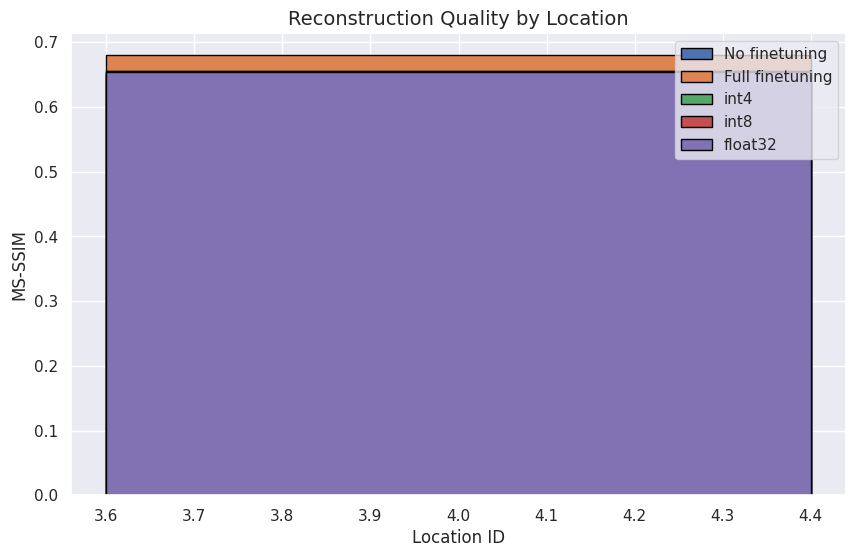

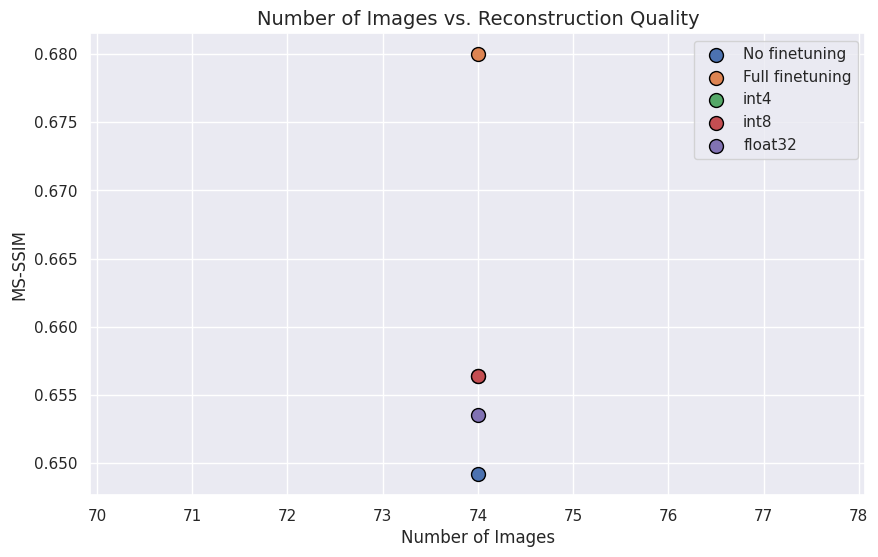

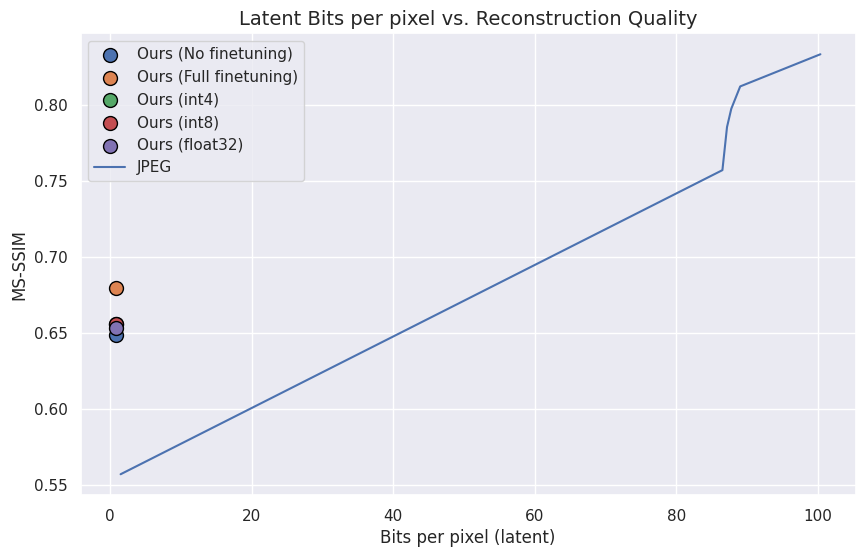

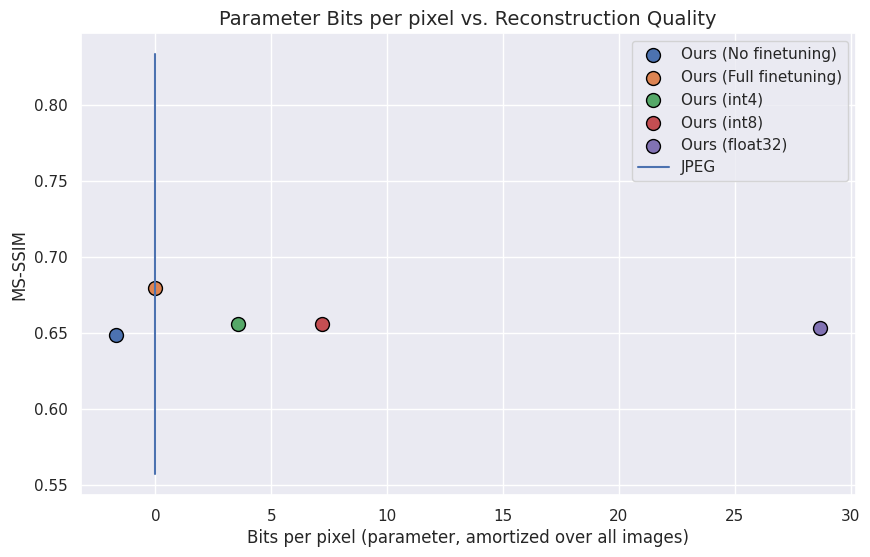

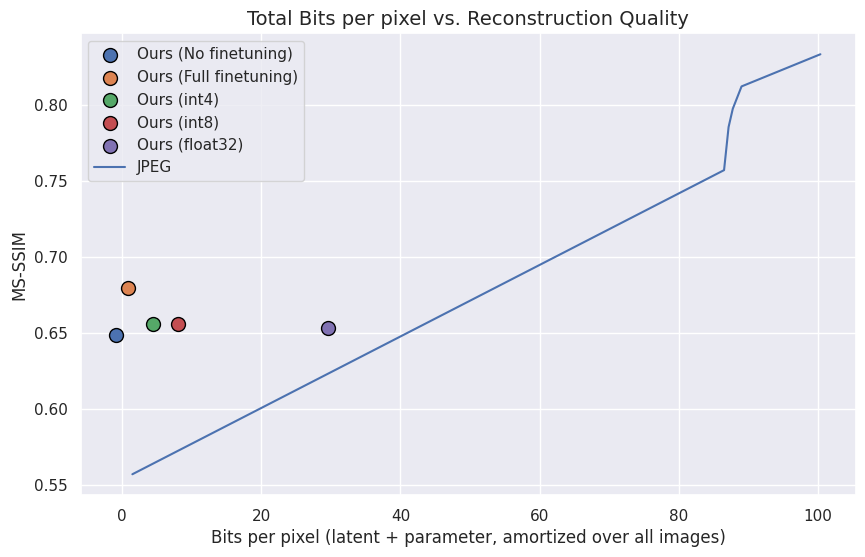

In [9]:
# Step 6: Visualize the results
# Bar chart of reconstruction error by location

lora_precision_labels = dict({ 32: "float32", 8: "int8", 4: "int4", 0: "Full finetuning", -1: "No finetuning" })

results_df["lora_precision"] = results_df["lora_precision"].fillna(-1)

has_mssim = True

# Bar chart
plt.figure(figsize=(10, 6))
for lora_precision in results_df["lora_precision"].unique():
    plt.bar(results_df[results_df["lora_precision"] == lora_precision]["loc_id"], results_df[results_df["lora_precision"] == lora_precision]["test_ms_ssim" if has_mssim else "test_ssim"], edgecolor='black', label=lora_precision_labels[lora_precision])
plt.xlabel("Location ID", fontsize=12)
plt.ylabel("MS-SSIM" if has_mssim else "SSIM", fontsize=12)
plt.title("Reconstruction Quality by Location", fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

# Scatter plot of number of images vs. reconstruction error
plt.figure(figsize=(10, 6))
for lora_precision in results_df["lora_precision"].unique():
    plt.scatter(results_df[results_df["lora_precision"] == lora_precision]["n_images"], results_df[results_df["lora_precision"] == lora_precision]["test_ms_ssim" if has_mssim else "test_ssim"], edgecolor='black', s=100, label=lora_precision_labels[lora_precision])
plt.xlabel("Number of Images", fontsize=12)
plt.ylabel("MS-SSIM" if has_mssim else "SSIM", fontsize=12)
plt.title("Number of Images vs. Reconstruction Quality", fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

# Latent Bits per pixel
plt.figure(figsize=(10, 6))
for lora_precision in results_df["lora_precision"].unique():
    plt.scatter(results_df[results_df["lora_precision"] == lora_precision]["latent_bpp"].mean(), results_df[results_df["lora_precision"] == lora_precision]["test_ms_ssim" if has_mssim else "test_ssim"].mean(), edgecolor='black', s=100, label=f"Ours ({lora_precision_labels[lora_precision]})")
jpeg_df_agg = jpeg_df.groupby("quality").mean(numeric_only=True)
plt.plot(jpeg_df_agg["bpp"], jpeg_df_agg["ms_ssim" if has_mssim else "ssim"], label="JPEG")
plt.xlabel("Bits per pixel (latent)", fontsize=12)
plt.ylabel("MS-SSIM" if has_mssim else "SSIM", fontsize=12)
plt.title("Latent Bits per pixel vs. Reconstruction Quality", fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

# Param Bits per pixel
plt.figure(figsize=(10, 6))
for lora_precision in results_df["lora_precision"].unique():
    plt.scatter((results_df[results_df["lora_precision"] == lora_precision]["param_bpp"] / results_df[results_df["lora_precision"] == lora_precision]["n_images"]).mean(), results_df[results_df["lora_precision"] == lora_precision]["test_ms_ssim" if has_mssim else "test_ssim"].mean(), edgecolor='black', s=100, label=f"Ours ({lora_precision_labels[lora_precision]})")
plt.plot(0 * jpeg_df_agg["bpp"], jpeg_df_agg["ms_ssim" if has_mssim else "ssim"], label="JPEG")
plt.xlabel("Bits per pixel (parameter, amortized over all images)", fontsize=12)
plt.ylabel("MS-SSIM" if has_mssim else "SSIM", fontsize=12)
plt.title("Parameter Bits per pixel vs. Reconstruction Quality", fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

# Total Bits per pixel
plt.figure(figsize=(10, 6))
for lora_precision in results_df["lora_precision"].unique():
    plt.scatter(results_df[results_df["lora_precision"] == lora_precision]["latent_bpp"].mean() + (results_df[results_df["lora_precision"] == lora_precision]["param_bpp"] / results_df[results_df["lora_precision"] == lora_precision]["n_images"]).mean(), results_df[results_df["lora_precision"] == lora_precision]["test_ms_ssim" if has_mssim else "test_ssim"].mean(), edgecolor='black', s=100, label=f"Ours ({lora_precision_labels[lora_precision]})")
plt.plot(jpeg_df_agg["bpp"], jpeg_df_agg["ms_ssim" if has_mssim else "ssim"], label="JPEG")
plt.xlabel("Bits per pixel (latent + parameter, amortized over all images)", fontsize=12)
plt.ylabel("MS-SSIM" if has_mssim else "SSIM", fontsize=12)
plt.title("Total Bits per pixel vs. Reconstruction Quality", fontsize=14)
plt.grid(True)
plt.legend()
plt.show()